<a href="https://colab.research.google.com/github/mcnica89/DATA6100_F23/blob/main/Subset_Selection_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6.5.1 Best Subset Selection

In [22]:
# imports and setup
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from itertools import chain, combinations
import statsmodels.api as sm

#pd.set_option('precision', 2) # number precision for pandas
#pd.set_option('display.max_rows', 12)
#pd.set_option('display.max_columns', 12)
#pd.set_option('display.float_format', '{:20,.2f}'.format) # get rid of scientific notation

#plt.style.use('seaborn') # pretty matplotlib plots

OptionError: ignored

In [15]:
### Use these to download from file
#hitters = pd.read_csv('../datasets/Hitters.csv', index_col=0).dropna()

#Get this link from github by clicking "view raw"
url = 'https://raw.githubusercontent.com/mcnica89/ISL-python/master/datasets/Hitters.csv'
hitters = pd.read_csv(url,index_col=0).dropna()
hitters.index.name = 'Player'


hitters = hitters.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,18]] # push salary at the end
hitters['League'] = pd.get_dummies(hitters['League']).iloc[:, 0]
hitters['Division'] = pd.get_dummies(hitters['Division']).iloc[:, 0]
hitters['NewLeague'] = pd.get_dummies(hitters['NewLeague']).iloc[:, 0]


X = hitters.iloc[:, 0:19] #stats
y = hitters.iloc[:, 19] #salary info

In [16]:
X

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,NewLeague
Player,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,0,0,632,43,10,0
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,1,0,880,82,14,1
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,0,1,200,11,3,0
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,0,1,805,40,4,0
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,1,0,282,421,25,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-Willie McGee,497,127,7,65,48,37,5,2703,806,32,379,311,138,0,1,325,9,3,0
-Willie Randolph,492,136,5,76,50,94,12,5511,1511,39,897,451,875,1,1,313,381,20,1
-Wayne Tolleson,475,126,3,61,43,52,6,1700,433,7,217,93,146,1,0,37,113,7,1


In [17]:
y

Player
-Alan Ashby           475.0
-Alvin Davis          480.0
-Andre Dawson         500.0
-Andres Galarraga      91.5
-Alfredo Griffin      750.0
                      ...  
-Willie McGee         700.0
-Willie Randolph      875.0
-Wayne Tolleson       385.0
-Willie Upshaw        960.0
-Willie Wilson       1000.0
Name: Salary, Length: 263, dtype: float64

# 6.5.3 Choosing Among Models Using the Validation Set Approach and Cross-Validation

Heavily borrowed from:

https://nbviewer.jupyter.org/url/www.science.smith.edu/~jcrouser/SDS293/labs/lab9/Lab%209%20-%20Linear%20Model%20Selection%20in%20Python.ipynb

In [18]:
#train test split!
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=3)

In [63]:
def processSubset(feature_set, X_train, y_train, X_test, y_test):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y_train,X_train[list(feature_set)])
    regr = model.fit()
    RMSE = float(np.sqrt(np.mean((regr.predict(X_test[list(feature_set)]) - y_test) ** 2)))
    return {'p':len(feature_set),'features':feature_set, 'model':regr, 'RMSE':RMSE}

In [64]:
def forward(predictors, X_train, y_train, X_test, y_test):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X_train.columns if p not in predictors]

    results = []

    for p in remaining_predictors:
        results.append(processSubset(predictors+[p], X_train, y_train, X_test, y_test))

    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)

    print("---------")
    for i in range(len(models)):
      print(f" Option #{i}: {models['features'][i]}")
      print(f" RMSE: {round(models['RMSE'][i],1)}")

    #print("----Models:\n", models['features']models['RMSE'])

    # Choose the model with the lowest RMSE
    best_model = models.loc[models['RMSE'].argmin()]

    # Return the best model, along with some other useful information about the model
    return best_model

In [91]:
models = pd.DataFrame(columns=['p','RMSE','features','model'])


predictors = []

for i in range(1,len(X.columns)+1):
    models.loc[i] = forward(predictors, X_train, y_train, X_test, y_test)
    predictors = models.loc[i]['model'].model.exog_names

models['RMSE'] = models['RMSE'].astype(float)

---------
 Option #0: ['AtBat']
 RMSE: 410.6
 Option #1: ['Hits']
 RMSE: 393.1
 Option #2: ['HmRun']
 RMSE: 470.3
 Option #3: ['Runs']
 RMSE: 400.7
 Option #4: ['RBI']
 RMSE: 395.1
 Option #5: ['Walks']
 RMSE: 419.2
 Option #6: ['Years']
 RMSE: 405.0
 Option #7: ['CAtBat']
 RMSE: 377.3
 Option #8: ['CHits']
 RMSE: 373.3
 Option #9: ['CHmRun']
 RMSE: 435.0
 Option #10: ['CRuns']
 RMSE: 372.0
 Option #11: ['CRBI']
 RMSE: 384.9
 Option #12: ['CWalks']
 RMSE: 414.9
 Option #13: ['League']
 RMSE: 571.6
 Option #14: ['Division']
 RMSE: 562.5
 Option #15: ['PutOuts']
 RMSE: 467.6
 Option #16: ['Assists']
 RMSE: 606.7
 Option #17: ['Errors']
 RMSE: 587.3
 Option #18: ['NewLeague']
 RMSE: 571.7
---------
 Option #0: ['CRuns', 'AtBat']
 RMSE: 333.9
 Option #1: ['CRuns', 'Hits']
 RMSE: 320.8
 Option #2: ['CRuns', 'HmRun']
 RMSE: 347.1
 Option #3: ['CRuns', 'Runs']
 RMSE: 322.8
 Option #4: ['CRuns', 'RBI']
 RMSE: 321.6
 Option #5: ['CRuns', 'Walks']
 RMSE: 345.3
 Option #6: ['CRuns', 'Years']
 RMS

In [92]:
#print results
models

,p,RMSE,features,model
1,1,371.975627,[CRuns],<statsmodels.regression.linear_model.Regressio...
2,2,305.737095,"[CRuns, PutOuts]",<statsmodels.regression.linear_model.Regressio...
3,3,305.450732,"[CRuns, PutOuts, CWalks]",<statsmodels.regression.linear_model.Regressio...
4,4,306.121136,"[CRuns, PutOuts, CWalks, Runs]",<statsmodels.regression.linear_model.Regressio...
5,5,302.347742,"[CRuns, PutOuts, CWalks, Runs, CRBI]",<statsmodels.regression.linear_model.Regressio...
6,6,300.222397,"[CRuns, PutOuts, CWalks, Runs, CRBI, League]",<statsmodels.regression.linear_model.Regressio...
7,7,299.550943,"[CRuns, PutOuts, CWalks, Runs, CRBI, League, A...",<statsmodels.regression.linear_model.Regressio...
8,8,288.586382,"[CRuns, PutOuts, CWalks, Runs, CRBI, League, A...",<statsmodels.regression.linear_model.Regressio...
9,9,288.117342,"[CRuns, PutOuts, CWalks, Runs, CRBI, League, A...",<statsmodels.regression.linear_model.Regressio...
10,10,287.750759,"[CRuns, PutOuts, CWalks, Runs, CRBI, League, A...",<statsmodels.regression.linear_model.Regressio...


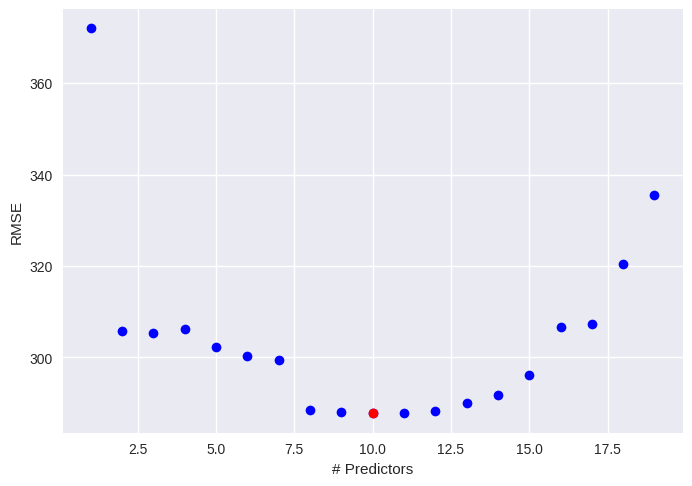

In [93]:
plt.plot(models['p'],models['RMSE'],'ob')
plt.xlabel('# Predictors')
plt.ylabel('RMSE')
plt.plot(models['p'][models['RMSE'].idxmin()], models['RMSE'].min(), 'or')

# Use the entire training Set (no test set)

In [95]:
models_no_test = pd.DataFrame(columns=['RMSE', 'model'])

predictors = []

for i in range(1,20):
    models_no_test.loc[i] = forward(predictors, X, y, X, y)
    predictors = models_no_test.loc[i]['model'].model.exog_names

---------
 Option #0: ['AtBat']
 RMSE: 414.0
 Option #1: ['Hits']
 RMSE: 405.4
 Option #2: ['HmRun']
 RMSE: 467.3
 Option #3: ['Runs']
 RMSE: 412.3
 Option #4: ['RBI']
 RMSE: 406.6
 Option #5: ['Walks']
 RMSE: 410.1
 Option #6: ['Years']
 RMSE: 436.5
 Option #7: ['CAtBat']
 RMSE: 418.7
 Option #8: ['CHits']
 RMSE: 414.4
 Option #9: ['CHmRun']
 RMSE: 461.5
 Option #10: ['CRuns']
 RMSE: 411.3
 Option #11: ['CRBI']
 RMSE: 417.6
 Option #12: ['CWalks']
 RMSE: 453.1
 Option #13: ['League']
 RMSE: 578.5
 Option #14: ['Division']
 RMSE: 546.6
 Option #15: ['PutOuts']
 RMSE: 509.3
 Option #16: ['Assists']
 RMSE: 606.9
 Option #17: ['Errors']
 RMSE: 557.2
 Option #18: ['NewLeague']
 RMSE: 579.0
---------
 Option #0: ['Hits', 'AtBat']
 RMSE: 404.4
 Option #1: ['Hits', 'HmRun']
 RMSE: 401.0
 Option #2: ['Hits', 'Runs']
 RMSE: 404.8
 Option #3: ['Hits', 'RBI']
 RMSE: 397.9
 Option #4: ['Hits', 'Walks']
 RMSE: 391.1
 Option #5: ['Hits', 'Years']
 RMSE: 370.0
 Option #6: ['Hits', 'CAtBat']
 RMSE: 35

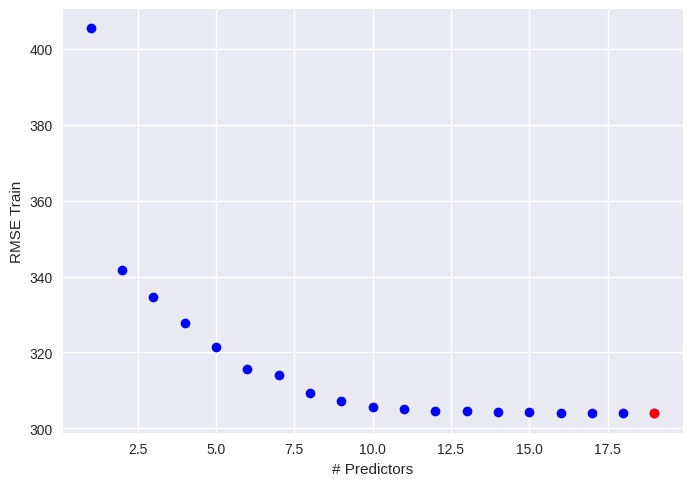

In [100]:
plt.plot(models_no_test['RMSE'],'ob')
plt.xlabel('# Predictors')
plt.ylabel('RMSE Train')
plt.plot(models_no_test['RMSE'].astype(float).idxmin(), models_no_test['RMSE'].min(), 'or');

In [103]:
print("Best 10 Variables from our training/test splitc:")
print(sorted(models.loc[10, 'model'].model.exog_names))

print("----")

print("Best 10 Variables using the entire model (no test set):")
print(sorted(models_no_test.loc[10, 'model'].model.exog_names))

Best 10 Variables from our training/test split:
['Assists', 'AtBat', 'CRBI', 'CRuns', 'CWalks', 'Division', 'Hits', 'League', 'PutOuts', 'Runs']
----
Best 10 Variables using the entire model (no test set):
['Assists', 'AtBat', 'CAtBat', 'CRBI', 'CRuns', 'CWalks', 'Division', 'Hits', 'PutOuts', 'Walks']
